In [1]:
from metpy.plots import *
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from metpy.io import *
import pandas as pd
import meteostat as mt
from datetime import datetime as dt
from dataclasses import dataclass
import metpy
import cv2
import os


@dataclass
class StationModelPlot:
    station_id: str = None
    path_to_file: str = None

    '''
    StationModelPlot Class accepts 
    Station_ID as String. ex:'12992' & 
    path_to_file as Path to file or file as object
    
    '''

    def fetch_station_data(self, start_time, end_time, obs_frequency='hourly'):
        """

        :param start_time: Start time to fetch data Ex: 2023-05-29 07:51:00
        :param end_time: End time to fetch data Ex: 2023-03-29 07:51:00
        :param obs_frequency: observation Frequency of data Ex. (Hourly, Daily)
        :return: Tuple of (CSV file, List)
                 containing CSV Data File of weather data and columns values of the data
        """
        frequency = ['hourly', 'daily']
        frequency_fetch = {'hourly': mt.Hourly,
                           'daily': mt.Daily
                           }
        if obs_frequency.lower() in frequency and start_time <= end_time:
            weather_data = frequency_fetch[obs_frequency](self.station_id, start_time, end_time)
            weather_data = weather_data.fetch()
            weather_data = weather_data.reset_index()
            data_parameters = list(weather_data.columns.values)
            return weather_data, data_parameters
        elif obs_frequency.lower() not in frequency:
            raise RuntimeError(
                f"Enter a valid observation frequency from {frequency} or Start time should be less than End time")

    def custom_file_read(self):
        """

        :return: A tuple containing Data Frame of Weather Data, list of column names
        """
        supported_types = ['nc', 'xml', 'txt', 'csv']
        extension_read = {'nc': xr.open_dataset,
                          'xml': pd.read_xml,
                          'txt': parse_metar_file,
                          'csv': pd.read_csv
                          }
        extension = self.path_to_file[self.path_to_file.rfind('.'):][1:]
        if extension not in supported_types:
            print(extension)
            print('txt' in supported_types)
            raise RuntimeError(f'Supported file formats are {supported_types}')
        elif extension == 'nc':
            weather_data = extension_read['nc'](self.path_to_file, engine="netcdf4")
            weather_data = weather_data.metpy.parse_cf()
            weather_data = weather_data.to_dataframe()
            weather_data = weather_data.reset_index()
            data_parameters = list(weather_data.columns.values)
        else:
            weather_data = extension_read[extension](self.path_to_file)
            if extension == 'csv':
                weather_data = weather_data.reset_index()
            # weather_data = weather_data.reset_index()
            data_parameters = list(weather_data.columns.values)
        return weather_data, data_parameters

    @staticmethod
    def parameter_validation(time_stamp_data: dict, data_columns: list):
        """

        :param time_stamp_data: A dictionary of all Parameters from weather data, weather data values
        :param data_columns: A list of Weather Parameter Abbreviations
        :return: Dictionary of valid Parameter names, values to plot
        """
        data_to_plot = {}
        parameter_abbreviations = {
            'station_id': ['Station_ID', 'station', 'station_id', 'STATION_ID', 'ID', 'id'],
            'date_time': ['valid', 'time', 'date_time', 'time1', 'time_stamp', 'DATE_TIME'],

            'temperature': ['Temperature', 'TEMPERATURE', 'tmpt', 'air_temperature',
                            'temp', 'tmpf', 'tmpc', 'temperature', 'tavg'],
            'dew_point_temperature': ['Dew_Point_Temperature', 'DEW_POINT_TEMPERATURE', 'dwpt', 'dwpc',
                                      'dew_temp', 'dwpf', 'dew_point_temperature'],
            'wind_speed': ['WIND_SPEED', 'wspd', 'sknt', 'Wind_Speed', 'wind_speed'],
            'wind_direction': ['WIND_DIRECTION', 'Wind_Direction', 'drct', 'wdir', 'wind_direction'],
            'cloud_height': ['skyl1', 'skyl2', 'skyl3', 'skyl4', 'highest_cloud_level', 'high_cloud_level',
                             'medium_cloud_level', 'low_cloud_level'],
            'pressure': ['PRESSURE', 'pres', 'mslp', 'atmospheric_pressure', 'air_pressure_at_sea_level'],
            'high_cloud': ['high_cloud_type', 'skyc3', 'high_cloud'],
            'mid_cloud': ['mid_cloud_type', 'skyc2', 'mid_cloud'],
            'low_cloud': ['low_cloud_type', 'skyc1', 'low_cloud'],
            'sky_cover': ['cloud_coverage', 'skyc1', 'sky_cover'],
            'visibility_distance': ['visibility', 'vsby', 'visibility_distance'],
            'present_weather': ['coco', 'current_weather', 'wxcodes', 'current_wx1', 'current_wx1_symbol',
                                'present_weather'],
            'past_weather': [],
            'pressure_tendency': [],
            'pressure_change': [],
            'pressure_difference': [],
            'precipitation': ['p01i', 'prcp', 'PRECIPITATION', 'precipitation'],
            'sky_cover_at_lowest_cloud': ['skyl1', 'SKY_COVER_AT_LOWEST_CLOUD', 'sky_cover_at_lowest_cloud',
                                          'cloud_coverage']
        }
        parameter_keys = list(parameter_abbreviations.keys())
        parameter_abb_list = list(parameter_abbreviations.values())
        parameters_values = []
        not_available_parameters = list()
        for abbrv_list in parameter_abb_list:
            for abbrvs in abbrv_list:
                parameters_values.append(abbrvs)
        for iteration in data_columns:
            if iteration in parameter_keys:
                data_to_plot[iteration] = time_stamp_data[iteration]
            elif iteration not in parameter_keys:
                if iteration in parameters_values:
                    for key, value in parameter_abbreviations.items():
                        if iteration in value:
                            index_key = key
                            data_to_plot[index_key] = time_stamp_data[iteration]
                elif iteration not in parameters_values:
                    not_available_parameters.append(iteration)

        if len(not_available_parameters) > 0:
            user_parameter = input(f'''parameter abbreviations {not_available_parameters} are not recognized to plot data, Please
                                select the parameter from {parameter_keys} to add an abbreviation:\t''')
            if user_parameter in parameter_keys:
                user_added_abbreviation = input('Enter abbreviation for the selected parameter:\t')
                parameter_abbreviations[user_parameter].append(user_added_abbreviation)
            else:
                print(f"Parameters {not_available_parameters} cannot be plotted in the Station model")
        return data_to_plot

    @staticmethod
    def plot_station_model(data: dict):
        """

        :param data: A dictionary containing data to plot into Station Model
        :return: Path to Image containing Station Model
        """
        fig, ax = plt.subplots(figsize=(10, 10))
        sp = StationPlot(ax, 0, 0, fontsize=13, spacing=25)
        ax.set_xlim(-8, 8)
        ax.set_ylim(-8, 8)
        ax.set_title('Station Model')
        station_square = plt.Rectangle((-6, -6), 12, 12, fc='white', ec="k")
        # ax.set_aspect()
        ax.add_patch(station_square)
        plot_dictionary = {
            # to add pressure_tendency symbol to the model
            'pressure_tendency': '''sp.plot_symbol((5, 0), codes=[data['pressure_tendency']],
                                symbol_mapper=pressure_tendency,va='center', ha='center', fontsize=25)''',

            # to add Sky_cover symbol to the model
            'sky_cover': "sp.plot_symbol((0, 0), codes=[data['sky_cover']], symbol_mapper=sky_cover, fontsize=25)",

            # to add pressure to the model
            'pressure': "ax.text(3, 3, s=str(round(data['pressure'])) + ' hPa', fontsize=13)",

            # to position wind-barb in the center of the model
            # u = [-wind_speed * np.sin(np.radians(wind_direction))] U component of wind barb
            # v = [-wspd_mps * math.cos(np.radians(wind_direction))] V component of wind barb
            'wind_speed': "sp.plot_barb(u=[-(data['wind_speed']) * np.sin(np.radians(data['wind_direction']))],"
                          "v=[-(data['wind_speed']) * np.cos(np.radians(data['wind_direction']))], length=11)",
            # to add wind speed in knots at the end of the barb
            'wind_direction': "ax.text(-1 * np.sin(np.radians(data['wind_direction'])),"
                              "-1 * np.cos(np.radians(data['wind_direction'])),str(data['wind_speed']) + ' kts',"
                              "ha='center', va='bottom', rotation=0, fontsize=10, alpha=0.3)",

            # to add height of the cloud base
            'cloud_height': "ax.text(-2, -3.5, s=str(data['cloud_height']), fontsize=13)",

            # to add dew_point_temperature to the model
            'dew_point_temperature': "ax.text(-3.5, -2.5, "
                                     "s=str(data['dew_point_temperature']) + '°C', fontsize=13)",

            # to add high_clouds symbol to the model
            'high_cloud': "ax.text(1.5, 4.5, s = str(data['high_cloud']), fontsize=13,"
                          " bbox=dict(boxstyle='round',facecolor='turquoise', alpha=0.7))",

            # to add low_clouds symbol to the model
            'low_cloud': "ax.text(-2, -2.5, s = str(data['low_cloud']), fontsize=13,"
                         "bbox=dict(boxstyle='round',facecolor='turquoise', alpha=0.2))",

            # to add mid_clouds symbol to the model
            'mid_cloud': "ax.text(1, 3, s = str(data['mid_cloud']), fontsize=13, "
                         "bbox=dict(boxstyle='round',facecolor='turquoise', alpha=0.5))",

            # to add past_weather symbol to the model
            'past_weather': "[sp.plot_symbol((2, -3.5), codes=[int(data['past_weather']], symbol_mapper=current_weather,va='center', ha='center', fontsize=25, "
                            "sp.plot_symbol((2, -3.5), codes=[wx_code_map[data['past_weather']]], symbol_mapper=current_weather,va='center', ha='center', fontsize=25]",

            # to add precipitation to the model
            'precipitation': "sp.plot_text((2, -5.5), text=[str(data['precipitation'])], fontsize=13)",

            # to add present_weather symbol to the model
            'present_weather': "sp.plot_symbol((-3.5, 0), codes=[int(data['present_weather'])], "
                               "symbol_mapper=current_weather,va='center', ha='center', fontsize=25)",

            # to add pressure_change to the model
            'pressure_change': "sp.plot_text((3.2, 0), text=[str(data['pressure_change'])], fontsize=13)",

            # to add pressure_difference to the model
            'pressure_difference': "sp.plot_text((4, 0), text=[str(data['pressure_difference'])], fontsize=13)",

            # to add sky_cover_of the lowest cloud to the model
            'sky_cover_at_lowest_cloud': "ax.text(-0.5, -2.5, "
                                         "s=str(data['sky_cover_at_lowest_cloud']), fontsize=13)",

            # to add temperature to the model
            'temperature': "ax.text(-3.5, 2, s = str(data['temperature'])+'°C', fontsize=13)",

            # to add visibility_distance to the model
            'visibility_distance': "ax.text(-4.5, 0, s=str(round(data['visibility_distance'])), fontsize=13)",

            # adds Station_ID to the model
            'station_id': "ax.text(2.8, 6.7, s =('Station ID: ' + data['station_id']), fontsize=13, weight=10)",

            'date_time': "ax.text(-0.5, 6.2, s = ('Date & Time:' + str(data['date_time']).rstrip('Timestamp()'))"
                         ", fontsize = 13, weight=10)"
        }
        for key, value in data.items():
            if key in plot_dictionary:
                eval(plot_dictionary[key])

        name = 'Station_model.jpeg'
        path = os.path.join(os.path.dirname('output'), name)
        plt.savefig(path, dpi=100)

        return path

    @staticmethod
    def get_time_stamp(time_stamp_string):
        """get_time_stamp method accepts argument as String in the format --> 'YYYY-MM-DD HH:MM' """
        ts = dt.strptime(time_stamp_string, '%Y-%m-%d %H:%M:%S')
        return ts
    
    @staticmethod
    def calculable_data(data, data_columns, timestamp_column, timestamp):
        prev_data = data[data[timestamp_column] == timestamp][]


Enter Time Stamp in valid format: YYYY-MM-DD HH:MM:SS
Enter Time Stamp in valid format: YYYY-MM-DD HH:MM:SS
Enter Time Stamp in valid format: YYYY-MM-DD HH:MM:SS
Parameters ['index', 'Unnamed: 0', 'latitude', 'longitude', 'elevation', 'wind_gust', 'current_wx2', 'current_wx3', 'medium_cloud_type', 'highest_cloud_type', 'altimeter', 'current_wx2_symbol', 'current_wx3_symbol', 'remarks', 'eastward_wind', 'northward_wind'] cannot be plotted in the Station model


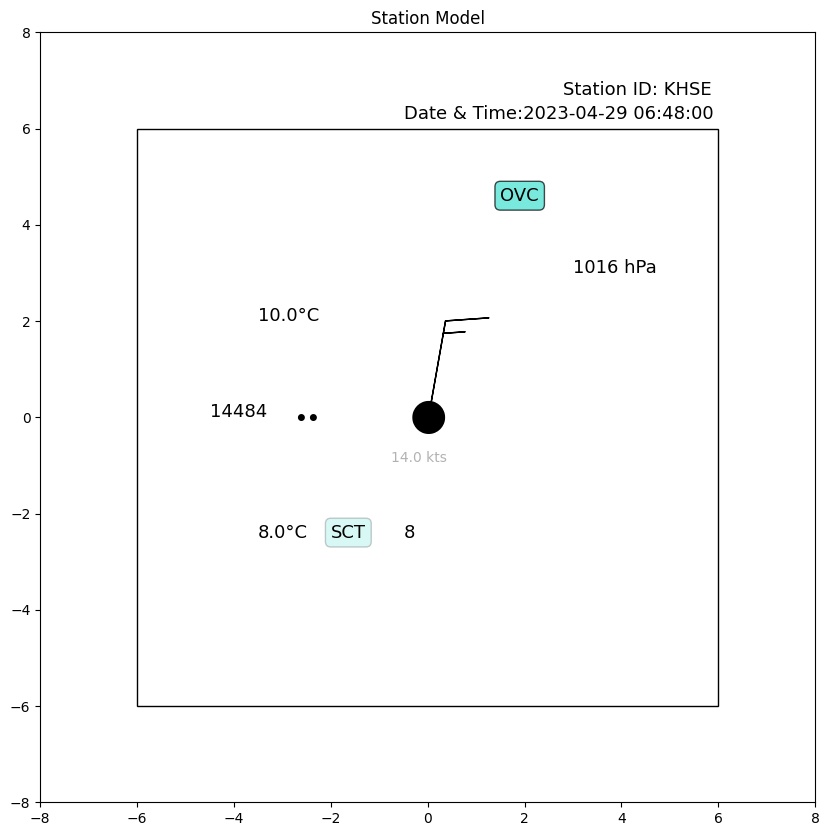

In [5]:
def main():
    obtain_method = {'fetch_data': 'Enter Valid Station ID to fetch data:\t',
                     'upload_data_file': 'Enter Path to file or File as object:\t'
                     }
    parameter_abb = {
        'date_time': ['valid', 'time', 'date_time', 'time1', 'time_stamp', 'DATE_TIME'],
    }
    while True:
        ip = input(
            f'''Enter a method from below: \n {list(obtain_method.keys())[0]}:(f), {list(obtain_method.keys())[1]}(u):\n''')
        if ip.lower() == 'f':
            st_id = input(obtain_method['fetch_data'])
            st = StationModelPlot(station_id=st_id)
            try:
                st_time = StationModelPlot.get_time_stamp(
                    input("Enter End time in format: 'YYYY-MM-DD HH:MM:SS ex. 2022-01-10 00:00:00 --:\n"))
                ed_time = StationModelPlot.get_time_stamp(
                    input("Enter End time in format: 'YYYY-MM-DD HH:MM:SS ex. 2022-01-20 00:00:00 --:\n"))
                freq = input("Enter observation Frequency from list [Hourly, Daily] : \t")
            
                fetched_data, fetched_data_columns = st.fetch_station_data(start_time=st_time, end_time=ed_time,obs_frequency=freq)
                fetched_data = fetched_data.fillna('')
            except Exception as e:
                print('Please Enter Valid Station ID , Valid Start time and End time in format: YYYY-MM-DD HH:MM:SS')
                continue
            pass
        elif ip.lower() == 'u':
            pt_to_file = input(obtain_method['upload_data_file'])
            try:
                st = StationModelPlot(path_to_file=pt_to_file)
                fetched_data, fetched_data_columns = st.custom_file_read()
                fetched_data = fetched_data.fillna('')
            except Exception as e:
                print('Entered Path File is Incorrect please enter a valid file path, or file as an object')
                continue
            pass
        else:
            continue
        date_abbreviations = {'date_time': ['valid', 'time', 'date_time', 'time1', 'time_stamp', 'DATE_TIME']}
        while True:
            try:
                for iter in range(len(date_abbreviations['date_time'])):
                    idx = date_abbreviations['date_time'][iter]
                    if idx in fetched_data_columns:
                        ts_column_name = fetched_data[idx]
                        ts = StationModelPlot.get_time_stamp(input(
                            f'Enter Time Stamp from {ts_column_name} in the format: "YYYY-MM-DD HH:MM:SS ex. 2022-01-10 00:00:00 --: \n'))
                        ts_data = fetched_data.loc[ts_column_name == ts]
                        ts_data = fetched_data.loc[ts_column_name == str(ts)]
                        ts_data = ts_data.squeeze()
                        ts_data = ts_data.fillna('')
                        break
                pass
            except Exception as e:
                print('Enter Time Stamp in valid format: YYYY-MM-DD HH:MM:SS')
                continue
            plot_data = StationModelPlot.parameter_validation(ts_data, fetched_data_columns)
            if ip == 'f':
                plot_data['station_id'] = st_id
            path = StationModelPlot.plot_station_model(data=plot_data)

            break
        break
    return path


if __name__ == '__main__':
    path_to_model = main()
    cv2.waitKey(10)
    img = cv2.imread(path_to_model)
    cv2.imshow('Station Model', img)
    key = cv2.waitKey(0) & 0xFF
    # if k == 27:  # close on ESC key
    #     cv2.destroyAllWindows()
    if key > -1:
        cv2.destroyAllWindows()
# /home/hp/example_metar.txt
# 2023-04-29 05:51:00
# 2023-04-29 07:08:00
# /home/hp/PycharmProjects/AWS-AWLR_Data_Analysis_Project/Station Model/data/test/weather_data.csv


,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
0,2018-01-07 12:00:00,25.8,9.6,36.0,NaN,NaN,NaN,0.0,NaN,1010.6,NaN,NaN
